# QMIND Workshop

In this workshop, we'll train and publish a CIFAR10 classifier to the Distributed Computer. This will allow us to submit a large number of tasks to a distributed computer to perform inference on a large number of images in parallel. 

Let's begin in python. 

In [1]:
%%capture
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
try:
    import tensorflowjs as tfjs
except:
    !pip install tensorflowjs tf-estimator-nightly 'ipykernel<5.0.0'
    import tensorflowjs as tfjs

In [3]:
(_xtrain, _ytrain), (_xtest, _ytest) = tf.keras.datasets.cifar10.load_data()
_xtrain = _xtrain.astype(np.float32) / 255.
_xtest  = _xtest.astype(np.float32)  / 255.

_ytrain_onehot = tf.keras.utils.to_categorical(_ytrain, 10)
_ytest_onehot  = tf.keras.utils.to_categorical(_ytest,  10)



print(_xtrain.min(), _xtrain.max(), _xtrain.dtype, _xtrain.shape, _ytest.shape)

0.0 1.0 float32 (50000, 32, 32, 3) (10000, 1)


In [4]:
class Classifier(tf.keras.Model):
    def __init__(self, num_classes, name=None):
        super(Classifier, self).__init__(name=name)
        self.num_classes = num_classes
        
        self.ls = [
            tf.keras.layers.Conv2D(32 ,3,strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64 ,3,strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(128,3,strides=2, padding='same', activation='relu'),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ]
    
    @tf.function
    def call(self,x):
        for l in self.ls:
            x = l(x)
        return x

In [5]:
model = Classifier(10)

model.compile(
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [6]:
_history = model.fit(_xtrain, _ytrain_onehot,
         batch_size=128,
         verbose=1,
         epochs=10,
         callbacks=[
             tf.keras.callbacks.EarlyStopping(patience=3)
         ],
         validation_data=(_xtest, _ytest_onehot))

Epoch 1/10
391/391 [==============================] - 5s 13ms/step - loss: 1.9909 - accuracy: 0.2493 - val_loss: 1.8496 - val_accuracy: 0.3017
Epoch 2/10
391/391 [==============================] - 5s 13ms/step - loss: 1.7544 - accuracy: 0.3493 - val_loss: 1.7620 - val_accuracy: 0.3540
Epoch 3/10
391/391 [==============================] - 5s 14ms/step - loss: 1.6134 - accuracy: 0.4075 - val_loss: 1.5352 - val_accuracy: 0.4357
Epoch 4/10
391/391 [==============================] - 5s 14ms/step - loss: 1.5081 - accuracy: 0.4478 - val_loss: 1.4416 - val_accuracy: 0.4726
Epoch 5/10
391/391 [==============================] - 5s 14ms/step - loss: 1.4236 - accuracy: 0.4788 - val_loss: 1.5520 - val_accuracy: 0.4343
Epoch 6/10
391/391 [==============================] - 5s 13ms/step - loss: 1.3529 - accuracy: 0.5075 - val_loss: 1.3149 - val_accuracy: 0.5221
Epoch 7/10
391/391 [==============================] - 5s 13ms/step - loss: 1.2888 - accuracy: 0.5304 - val_loss: 1.2830 - val_accuracy: 0.5315

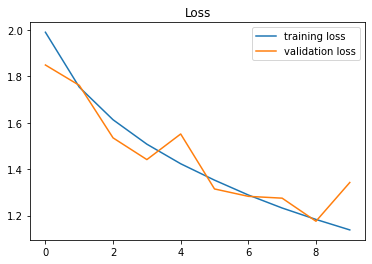

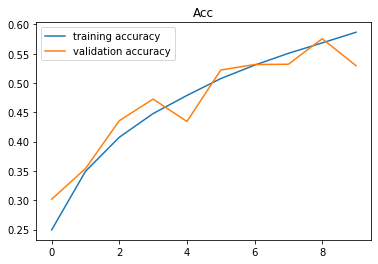

In [7]:
plt.title("Loss")
plt.plot(_history.history['loss'])
plt.plot(_history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.show()

plt.title("Acc")
plt.plot(_history.history['accuracy'])
plt.plot(_history.history['val_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])
plt.show() 

# Publishing our model

Now we'll clone this helpful tensorflowjs utility and use tensorflowjs converter to convert our python model to a tensorflowjs model and then publishing this model to the Distributed Computer.


In [8]:
%%capture
!git clone https://github.com/Kings-Distributed-Systems/tfjs_util.git
!cd tfjs_util && npm i && npm run postinstall 

In [10]:
!mkdir -p './tfjs_model'
!mkdir -p './saved_model'
model.save('./saved_model')
tfjs.converters.convert_tf_saved_model('./saved_model', './tfjs_model')
#Serialize and submit model to DCP package manager with version number X.X.XX 
!node /home/mgasmallah/DCP/dcp-utils/tfjs_utils/bin/serializeModel.js -m ./tfjs_model/model.json \
    -o dcp_cifar_10_ex/cifar10.js -p 0.0.6 -d
!rm -rf ./tfjs_model ./saved_model

Writing weight file ./tfjs_model/model.json...
2020-09-29 14:55:26.272244: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-09-29 14:55:26.314798: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2599990000 Hz
2020-09-29 14:55:26.315268: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4fd8b60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-09-29 14:55:26.315286: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Module published at :  dcp_cifar_10_ex/cifar10.js
Done!


# Pixiedust-node

Now we'll use a library that will enable us to run javascript in a jupyter notebook so that we can use the Distributed Compute Protocol to submit inference jobs to the cloud.

In [12]:

#!pip install pixiedust git+https://github.com/Kings-Distributed-Systems/pixiedust_node#egg=pixiedust_node

In [13]:
# %%capture
import pixiedust
import pixiedust_node

npm.install( ['dcp-client'] )

Pixiedust database opened successfully


pixiedust_node 0.2.5 started. Cells starting '%%node' may contain Node.js code.


/home/mgasmallah/.nvm/versions/node/v10.20.1/bin/npm install -s github:Kings-Distributed-Systems/npy-js
+ npy-js@1.0.0
updated 1 package and audited 1370 packages in 3.634s
18 packages are looking for funding
run `npm fund` for details
found 29 vulnerabilities (13 low, 16 moderate)
run `npm audit fix` to fix them, or `npm audit` for details
/home/mgasmallah/.nvm/versions/node/v10.20.1/bin/npm install -s dcp-client
+ dcp-client@3.2.1
updated 1 package and audited 1370 packages in 2.748s
18 packages are looking for funding
run `npm fund` for details
found 29 vulnerabilities (13 low, 16 moderate)
run `npm audit fix` to fix them, or `npm audit` for details


In [14]:
ID_KEY_LOC = '/home/mgasmallah/DCP/keys/id.keystore'
ACC_KEY_LOC= '/home/mgasmallah/DCP/keys/AISTEST.keystore'
SCHEDULER  = 'https://demo-scheduler.distributed.computer'

node.clear();
!job-utility cancelAllJobs -I $ID_KEY_LOC --default-bank-account-file $ACC_KEY_LOC --scheduler $SCHEDULER

Clearing context...
Sending request cancelAllJobs...
{
  "description": "Cancelled 0 jobs.",
  "stats": []
}


In [15]:
%%node

process.argv.push('-I', ID_KEY_LOC, '--default-bank-account-file', ACC_KEY_LOC, '--scheduler', SCHEDULER)
require('dcp-client').initSync(process.argv)
const compute = require('dcp/compute');
const wallet = require('dcp/wallet');
const dcpCli = require('dcp/dcp-cli');

var accountKeystore;
var identityKeystore;

(async function(){
    identityKeystore = await dcpCli.getIdentityKeystore();
    wallet.addId(identityKeystore);
    accountKeystore = await dcpCli.getAccountKeystore();
    console.log("Keystores loaded!");
})();

Keystores loaded!


In [16]:
sample_cifar = _xtest[:100]
cifar_true   = _ytest_onehot[:100]

sample_cifar.shape, sample_cifar[0,0,0,0], cifar_true.shape, cifar_true.dtype

((100, 32, 32, 3), 0.61960787, (100, 10), dtype('float32'))

In [17]:
%%node
var cifarResults = []
async function main(){
    let x = Float32Array.from(sample_cifar.typedArray);
    let y = Float32Array.from(cifar_true.typedArray);
    
    console.log(x[0]);
    
    let submission_array = [];
    let num_elem_x = sample_cifar.shape[1]*sample_cifar.shape[2]*sample_cifar.shape[3];
    let num_elem_y = cifar_true.shape[1];
    for (let i = 0; i < sample_cifar.shape[0]; i++){
        submission_array.push(
            {
            'x': Array.from(x.slice(i*num_elem_x, (i+1) * num_elem_x)),
            'y': Array.from(y.slice(i*num_elem_y, (i+1) * num_elem_y))   
            }
        );
    }
    
    let job = compute.for( submission_array, async function(data){
        
        progress(0.);
        const tf = require('tfjs');
        tf.setBackend('cpu');
        await tf.ready();
        progress(0.15);
        const model = await require('cifar10').getModel();
        progress(0.45);
        let inpTensor = tf.tensor(data.x, [1, 32, 32, 3], dtype='float32');
        let y_true    = tf.tensor(data.y, [1, 10], dtype='int32');
        progress(0.5);
        let y_pred = model.predict(inpTensor);
        progress(0.75);
        const accuracyTensor = tf.metrics.categoricalAccuracy(y_true, y_pred);
        progress(0.85);
        const acc = accuracyTensor.dataSync()[0];
        progress(1.);
        return acc;
    });
    
    
    job.on('accepted', ()=>{
        console.log("Job Accepted...");
    });
    
     job.on('status', (status)=>{
         console.log("Received a status update: ", status);
     });
    job.on('result', (value)=>{
        cifarResults.push(value.result);
        
    })
    job.on('console', (output)=>{
        console.log(output.message);
    })
    job.on('error', (err)=>{
        console.log(err);
    })
    
    job.requires('aistensorflow/tfjs');
    job.requires('dcp_cifar_10_ex/cifar10')
    
//    job.requirements.environment.offscreenCanvas = true;
    job.public.name = 'dcp-workshop';
    
    await job.exec(compute.marketValue, accountKeystore);
    
    console.log("Done Executing job!");
}

main();

0.6196078658103943

Job Accepted...
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 0, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 1, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 2, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 3, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 4, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 5, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 6, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 7, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 8, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 9, computed: 0 }
Received a status update

In [18]:
print("Accuracy on distributed 100 set sample: ", sum(cifarResults)/len(cifarResults))

Accuracy on distributed 100 set sample:  0.52


# Your turn!

Now try it with something like the fashion mnist dataset!

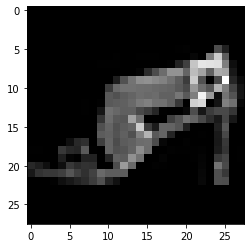

In [16]:
(_xtrain, _ytrain), (_xtest, _ytest) = tf.keras.datasets.fashion_mnist.load_data()


plt.imshow(_xtrain[np.random.randint(_xtrain.shape[0])], cmap='gray')
plt.show()